# Analyzing Nobel Prizes with DuckDB

[DuckDB](https://duckdb.org/) is a fast in-process OLAP relational DBMS that is a lot like SQLite but instead is **columnar** rather than **row-oriented**.

It has a lot of nice ergonomics, f.i., you can load CSVs and JSONs into tables straight from HTTP, a feature we are going to make use of in this notebook.

## Set up Jupyter notebook

In [ ]:
%pip install duckdb duckdb-engine jupysql seaborn

In the following cell we initialize the excellent [JupySQL extension](https://jupysql.ploomber.io/en/latest/quick-start.html) and connect to an in-memory DuckDB.

We also configure JupySQL to transparently convert query results to pandas dataframes.

In [2]:
%load_ext sql
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

%sql duckdb://

We need to install and load the [httpfs extension for DuckDB](https://duckdb.org/docs/extensions/httpfs) to be able to read data files from the web:

In [3]:
%%sql

INSTALL httpfs;
LOAD httpfs

,Success


## Download dataset into DuckDB

We download relevant data from the [Nobel Prize API](https://www.nobelprize.org/about/developer-zone-2/).

OpenAPI: [https://app.swaggerhub.com/apis/NobelMedia/NobelMasterData/2.1](https://app.swaggerhub.com/apis/NobelMedia/NobelMasterData/2.1)

In [4]:
API_URL = "https://api.nobelprize.org/2.1"

In [5]:
%%sql

create table raw_laureates as (

    select unnest(laureates) as laureate
    from read_json_auto('{{API_URL}}/laureates?offset=0\&limit=2000')

)

,Success


## Processing the dataset into distinct tables

### Create a table of all laureates who are persons

In [6]:
%%sql

create table laureates_person as (

    select

        laureate.id as laureate_id,
        laureate.fullName.en as full_name,
        laureate.gender as gender,
        case
            when laureate.birth.date ~~ '%-00-00'
                then null
            else laureate.birth.date::date
        end as birth_date,
        laureate.death.date::date as death_date,
        laureate.birth.place.locationString.en as birth_place,
        laureate.birth.place.countryNow.en as birth_country,

    from raw_laureates

    where laureate.fullName is not null

)

,Success


### Create a table of all laureates who are organizations

In [7]:
%%sql

create table laureates_organization as (

    select

        laureate.id as laureate_id,
        laureate.orgName.en as org_name,

    from raw_laureates

    where laureate.orgName is not null

)

,Success


### Create a table of all individually awarded Nobel Prizes

In [8]:
%%sql

create table prizes as (

    select

        laureate_id,
        laureate_type,
        prize.awardYear as award_year,
        lower(replace(prize.category.en, ' ', '-')) as category_slug,
        prize.sortOrder as prize_sort_order,
        prize.dateAwarded::date as date_awarded,
        prize.portion as prize_portion,
        prize.motivation.en as motivation,
        prize.prizeStatus as prize_status,

    from (

        select

            laureate.id as laureate_id,
            case
                when laureate.fullName is not null
                    then 'person'
                else 'organization'
            end as laureate_type,
            unnest(laureate.nobelPrizes) as prize

        from raw_laureates
        
    ) as t

    order by
        award_year,
        date_awarded,
        prize_sort_order

)

,Success


## Analysis

We import and set up `seaborn` for statistical visualization.

In [9]:
import seaborn as sns

sns.set_theme()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.set_style("darkgrid")
sns.set_palette("dark")


In [10]:
# avoids certain future warnings originating from seaborn internally using deprecated pandas APIs
import warnings

warnings.filterwarnings("ignore")

### Analyzing female laureates

#### Total count of female laureates

In [11]:
%sql select count(1) as female_laureates_count from laureates_person where gender == 'female'

,female_laureates_count
0,60


In the following snippet `df <<` assigns the query result as pandas dataframe to the local variable `df` instead of returning it as cell output.

In [12]:
%%sql df <<

with

long_form as (

    select

        p.category_slug,
        case
            when p.laureate_type = 'person'
                then lp.gender
            else p.laureate_type
        end as gender_or_org,

    from prizes as p
    left join laureates_person as lp using (laureate_id)

),

pivoted as ( pivot long_form on gender_or_org ),

with_total as (

    select
        
        *,
        (female + male + organization) as total,

    from pivoted

)

select * from with_total order by total asc

Plot the captured dataframe:

In [13]:
df

,category_slug,female,male,organization,total
0,economic-sciences,2,90,0,92
1,literature,17,102,0,119
2,peace,18,92,30,140
3,chemistry,8,183,0,191
4,physics,4,218,0,222
5,physiology-or-medicine,12,213,0,225


Visualize those numbers as bar chart:

<Axes: title={'center': 'Nobel Prizes by prize category and gender or organization'}>

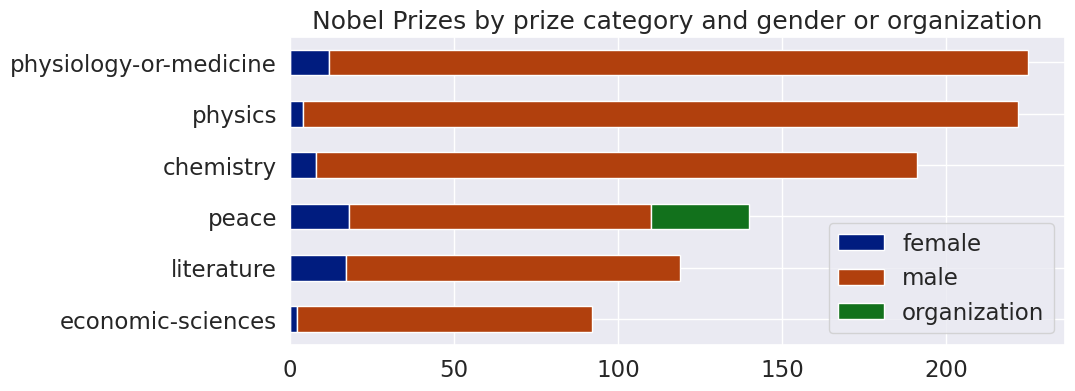

In [14]:
(
    df.drop("total", axis="columns")
    .set_index("category_slug")
    .plot.barh(
        stacked=True,
        figsize=(10, 4),
        title="Nobel Prizes by prize category and gender or organization",
        ylabel="",
    )
)

### Analyzing average age of laureates

We calculate a simple moving average over the period since the Nobel Prize was established.

Here, we specify a window size of 15 years:

In [15]:
WINDOW_SIZE = 15

In [16]:
%%sql df <<

with

prizes_with_age as (

    select

        p.award_year,
        p.category_slug,
        date_diff('year', l.birth_date, p.date_awarded) as age_at_award,
    
    from prizes as p
    join laureates_person as l using (laureate_id)
    
),

avg_age as (

    select distinct

        award_year,
        category_slug,
        avg(age_at_award) over(
            partition by category_slug
            order by award_year
            range between {{WINDOW_SIZE - 1}} preceding and current row
        ) as avg_age_at_award,
    
    from prizes_with_age

)

select *
from avg_age
order by award_year asc

Plot the results as line chart:

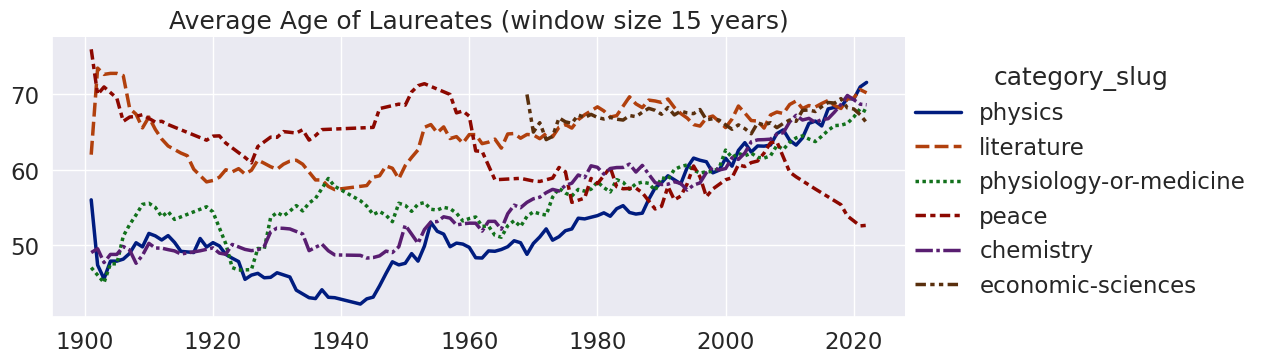

In [17]:
sns.relplot(
    data=df,
    x="award_year",
    y="avg_age_at_award",
    hue="category_slug",
    style="category_slug",
    kind="line",
    height=4,
    aspect=2.5,
).set(
    title=f"Average Age of Laureates (window size {WINDOW_SIZE} years)",
    xlabel="",
    ylabel="",
)


- Initially, laureates in sciences tended to be around 10 years younger than laureates in Literature and Peace. 
- Since the 1980s sciences have caught up and reached a similar age around the age of 65 years.
- Nobel Peace Prize is the exception to this trend.